In [1]:
import scipy.signal
import scipy.interpolate

import numpy as np

import matplotlib.pyplot as plt

In [2]:
b, a = [0.00027012, 0.00081037, 0.00081037, 0.00027012], \
       [ 1.        , -2.28382154,  1.77001169, -0.46444682]

Ts = 0.00075
Fs = 1 / Ts
N = 100
D = 2000

t = np.linspace(0, N / Fs, num=N, endpoint=False)

np.random.seed(10)
x = np.random.randn(N)
y = scipy.signal.lfilter(b, a, x)

In [3]:
def delay_filter(M):
    def filter(x):
        b = np.zeros(shape=(M + 1, ))
        b[-1] = 1
        return scipy.signal.lfilter(b=b, a=[1], x=x)

    return filter

def causal_cubic_spline_filter(M=20):
    alpha = np.sqrt(3) - 2

    # Truncated backward filter
    hb = -1 * (alpha ** np.arange(M + 1, 0, step=-1))

    def filter(y):
        yb = scipy.signal.lfilter(b=hb, a=[1], x=y)
        wc = scipy.signal.lfilter(b=[1], a=[1, -alpha], x=yb)
        return wc

    return filter

def causal_cubic_coefficients(w, yd):
    def filter(x, b):
        return scipy.signal.lfilter(b=b, a=[1], x=x)

    Tcw = [[3, 3, -3, -3],
           [-3, -6, 3, 6],
           [0, 3, 0, -3],
           [0, 0, 0, 0]]
    Tcy = [[0, -2, 2],
           [0, 3, -3],
           [0, 0, 0],
           [0, 0, 1]]

    return [filter(w, Tcw[i]) + filter(yd, Tcy[i]) for i in range(4)]

def causal_cubic_interpolate(y, order):
    def cubic_poly(dx, d, c, b, a):
        return d * (dx ** 3) + c * (dx ** 2) + b * dx + a

    M = 20
    dx = np.linspace(0, 1, num=order)

    w = causal_cubic_spline_filter(M=M)(y)
    yd = delay_filter(M=M)(y)

    [d, c, b, a] = causal_cubic_coefficients(w, yd)
    yi = np.zeros(shape=(y.shape[0] * order,))
    for n in range(d.shape[0]):
        yi[n * order:(n + 1) * order] = cubic_poly(dx, d[n], c[n], b[n], a[n])

    return yi, (M + 2) * order

MSE: {-58.89491586728495} [dB]


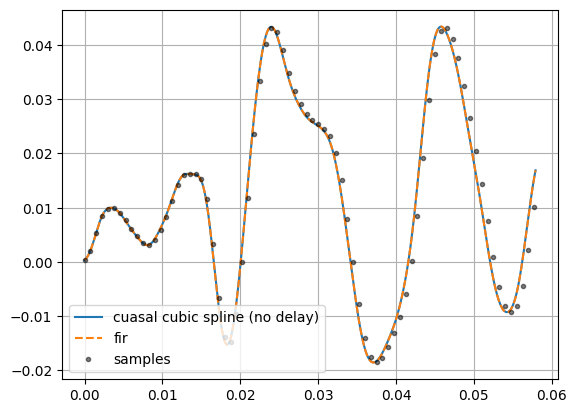

In [4]:
def interp_error(yic, yf, y):
    return 20 * np.log10(np.std(yic - yf) / np.std(y))

ti = np.linspace(0, t[-1], num=D * t.shape[0])
yf = scipy.signal.resample_poly(y, up=D, down=1)

yic, id = causal_cubic_interpolate(np.real(y), order=D)
yic = yic + 1j * causal_cubic_interpolate(np.imag(y), order=D)[0]

E = {interp_error(yic[id:], yf[:-id], y)}
print(f"MSE: {E} [dB]")

plt.grid(True)
plt.plot(ti[:-id], np.real(yic[id:]), label='cuasal cubic spline (no delay)')
plt.plot(ti[:-id], np.real(yf[:-id]), '--', label='fir')
plt.plot(t[:-id // D], np.real(y[:-id // D]), 'o', color='black', markersize=3, alpha=0.5, label='samples')
plt.legend()
plt.show()